In [1]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model
from comp_preprocessing import get_data, select_data

from comp_causalmodel import causal_eval, model, bootstrap_effects, placebo_effects, bootstrap_marginal
from comp_postivitree import learn_rules

import numpy as np
import pandas as pd

from matplotlib_venn import venn2, venn3
%load_ext autoreload
%autoreload 2

In [3]:
folder = '/home/victora/PositivityViolation/'

In [4]:
data = select_data(data_path=folder + 'data/ET_2016_Preprocessed_newT.csv')
data[['treatment', 'outcome']].groupby(['treatment']).mean()

,outcome
treatment,
0,0.042301
1,0.030440


In [73]:
DATA_PATH = folder + 'data/fp_select_overlap_ptree.csv'
X_df, a, y = get_data(data_path=DATA_PATH, encode=False)

In [74]:
# ipw = model(data_path=folder + 'nhefs_select.csv', encode=False)
# ipw = model(data_path=DATA_PATH, encode=False)
# p = ipw.compute_propensity(X_df, a)
# df = pd.DataFrame({'treatment': a, 'propensity': p})
# df.to_csv('propensities-ke-ptree.csv', index=False)

100%|██████████| 2000/2000 [00:07<00:00, 267.40it/s]


(-0.009420288837474533, -0.03752256195232095, 0.01647737058835706)

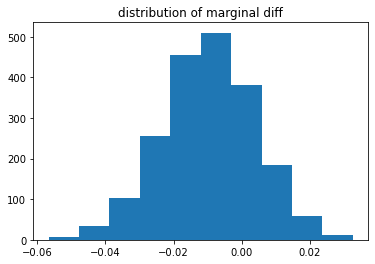

In [95]:
bootstrap_marginal(data_path=DATA_PATH)

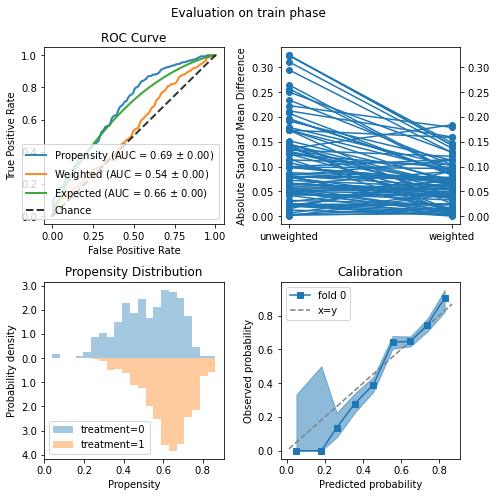

In [96]:
evaluations, X_test, a_test, y_test = model(data_path=DATA_PATH, encode=False)

In [97]:
X_test.shape

(783, 94)

In [98]:
evaluations.scores.covariate_balance.sort_values(by='unweighted', ascending=False).head(3)

abs_smd,weighted,unweighted
covariate,,
v102_1,0.142841,0.324178
v102_2,0.142841,0.324178
v101_10,0.147906,0.323463


100%|██████████| 1000/1000 [00:13<00:00, 73.63it/s]


(-0.007567071544660303, -0.03658464567893531, 0.018926807571294748)

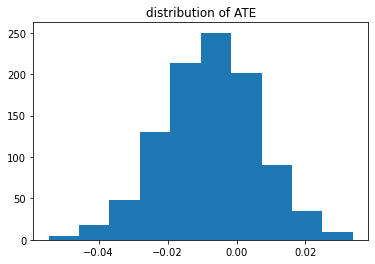

In [99]:
bootstrap_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000)

100%|██████████| 1000/1000 [02:12<00:00,  7.55it/s]


-0.00019163782655557998

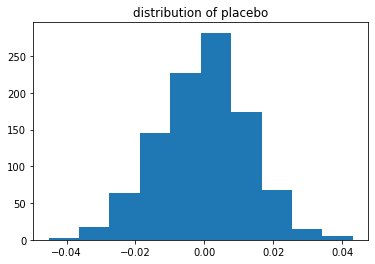

In [100]:
placebo_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000)

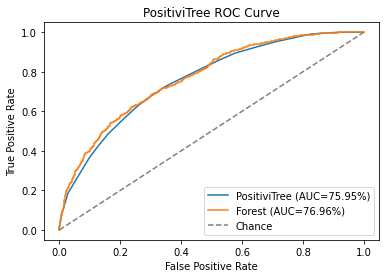

In [81]:
scores, voilating_index, transcript = learn_rules(data_path=DATA_PATH)

In [82]:
print(transcript)
print(1 - len(voilating_index)/len(X_df))

[[('Region', 'Addis Adaba', '=', 0), ('Region', 'Dire Dawa', '=', 0), ('Current use by method type', 'Traditional method', '=', 0), ('Region', 'Harari', '=', 0), ('Desire for more children', 'Sterilized (respondent or partner)', '=', 0), ('Time since last menstrual period', '', '>', 228.5), ('Recent sexual activity', 'Active in last 4 weeks', '=', 1), ('Region', 'Tigray', '=', 0), ('Ideal number of children', '', '>', 97.0)], [('Region', 'Addis Adaba', '=', 0), ('Region', 'Dire Dawa', '=', 0), ('Current use by method type', 'Traditional method', '=', 0), ('Region', 'Harari', '=', 0), ('Desire for more children', 'Sterilized (respondent or partner)', '=', 1)], [('Region', 'Addis Adaba', '=', 0), ('Region', 'Dire Dawa', '=', 0), ('Current use by method type', 'Traditional method', '=', 1)], [('Region', 'Addis Adaba', '=', 1), ('Current use by method type', 'Traditional method', '=', 1)]]
0.9570799706529713


In [31]:
ptree_vindex = voilating_index

knn_vindex = [1025, 1026, 1027, 1539, 1029, 1030, 1542, 2052, 521, 1033, 1034, 1545, 1546, 15, 2576, 18, 1044, 1045, 1049, 2074, 2585, 2076, 1053, 33, 545, 1057, 2084, 2597, 551, 552, 1576, 1069, 2606, 559, 2607, 561, 2610, 51, 2615, 571, 576, 1089, 1091, 70, 582, 1610, 1100, 1104, 1105, 598, 2656, 2658, 1125, 1126, 104, 1128, 2152, 107, 1132, 2664, 2158, 1651, 1140, 2675, 1142, 1147, 1148, 637, 125, 2171, 1664, 2173, 2175, 1667, 1668, 1669, 1670, 1159, 2183, 2184, 2690, 1675, 2693, 1679, 1169, 2193, 2705, 150, 2719, 2208, 163, 164, 2723, 166, 167, 680, 169, 170, 682, 172, 173, 686, 684, 1707, 689, 178, 1713, 2220, 2221, 2222, 695, 696, 2224, 2244, 198, 1222, 1223, 2248, 714, 1742, 2687, 1744, 1748, 2688, 214, 1764, 742, 231, 1768, 1259, 1260, 1773, 1774, 751, 1263, 2287, 1266, 2289, 1268, 1269, 246, 1270, 1271, 1275, 1282, 259, 2307, 2309, 774, 1800, 778, 2315, 270, 1806, 1808, 787, 1815, 794, 1819, 796, 797, 2334, 1311, 2336, 1825, 2339, 1318, 2343, 808, 2344, 810, 1326, 815, 2350, 817, 818, 819, 820, 309, 2351, 2352, 2353, 2355, 2358, 2359, 1344, 1345, 1350, 1353, 2388, 341, 342, 855, 346, 2394, 1884, 1885, 2400, 1891, 871, 1385, 874, 1392, 1904, 370, 885, 1911, 376, 1401, 1402, 1407, 2434, 1923, 390, 2215, 395, 397, 2217, 2453, 2218, 2457, 924, 2460, 414, 415, 1951, 419, 1956, 1957, 1446, 1958, 1959, 1961, 426, 1963, 1964, 941, 942, 943, 944, 433, 946, 1965, 954, 1980, 964, 1992, 459, 2508, 475, 2015, 2535, 490, 1516, 494, 2545, 1529, 507, 1022, 1023]

clr_vindex = [4, 2052, 23, 2074, 2076, 31, 2079, 33, 2084, 43, 44, 2092, 51, 52, 2103, 65, 2114, 70, 2124, 2133, 91, 96, 98, 2152, 104, 2158, 111, 125, 2173, 2175, 2183, 144, 150, 2207, 2208, 2209, 162, 163, 164, 165, 166, 167, 168, 169, 170, 2210, 2212, 2221, 2222, 175, 2215, 2216, 178, 2218, 2219, 2223, 2224, 2231, 186, 2244, 2245, 198, 2248, 205, 218, 231, 2289, 246, 259, 2315, 270, 2325, 278, 2327, 2330, 2336, 2338, 2340, 2343, 2344, 2345, 2347, 2348, 2349, 2350, 2351, 2352, 304, 306, 2355, 2356, 309, 310, 2357, 2358, 326, 2388, 341, 342, 346, 2395, 348, 2399, 2400, 2403, 2415, 2432, 388, 389, 395, 2453, 2460, 415, 416, 417, 419, 2468, 2471, 423, 426, 432, 439, 442, 2507, 2509, 2510, 2521, 490, 2544, 499, 2554, 507, 509, 2558, 521, 2585, 2589, 559, 561, 562, 2610, 2615, 571, 576, 588, 604, 605, 2662, 2664, 618, 622, 2675, 628, 634, 2686, 2687, 2688, 2690, 2693, 2700, 2719, 2720, 2723, 2725, 680, 682, 683, 684, 685, 686, 695, 696, 729, 751, 778, 785, 795, 796, 797, 798, 801, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 847, 855, 856, 885, 886, 2213, 2214, 903, 2217, 919, 921, 933, 934, 941, 944, 945, 947, 948, 950, 954, 967, 986, 989, 991, 1004, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1034, 1044, 1045, 1049, 1053, 1057, 1067, 1068, 1069, 1077, 1091, 1104, 1125, 1126, 1128, 1129, 1130, 1131, 1132, 1140, 1142, 1147, 1148, 1160, 1169, 1173, 1203, 1205, 1207, 1208, 1209, 1222, 1223, 1226, 1259, 1260, 1261, 1263, 1264, 1265, 1266, 1268, 1269, 1270, 1271, 1275, 1277, 1310, 1316, 1318, 1319, 1326, 1337, 1339, 1345, 1353, 1392, 1394, 1401, 1407, 1429, 1437, 1445, 1446, 1516, 1526, 1538, 1541, 1542, 1544, 1545, 1546, 1549, 1596, 1606, 1610, 1615, 1629, 1633, 1634, 1643, 1651, 1655, 1660, 1667, 1668, 1670, 1710, 1715, 1721, 1742, 1744, 1748, 1754, 1765, 1773, 1774, 1800, 1801, 1806, 1815, 1819, 1863, 1868, 1884, 1885, 1887, 1890, 1891, 1904, 1922, 1923, 1924, 1956, 1957, 1958, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1980, 1982, 1984, 1986, 1987, 1989, 1992, 1997, 2011, 2012, 2014, 2015, 2040]


support_vindex = [  33,   51,   70,  104,  125,  150,  178,  198,  231,  259,  270,
             309,  341,  342,  346,  395,  415,  419,  426,  490,  507,  521,
             571,  576,  695,  696,  751,  778,  796,  797,  855,  885,  954,
            1044, 1045, 1049, 1053, 1057, 1069, 1091, 1104, 1125, 1140, 1142,
            1147, 1148, 1169, 1222, 1223, 1275, 1326, 1345, 1353, 1401, 1407,
            1516, 1610, 1651, 1667, 1668, 1670, 1742, 1744, 1748, 1773, 1774,
            1806, 1819, 1891, 1904, 2015, 2052, 2074, 2076, 2084, 2152, 2158,
            2173, 2175, 2244, 2248, 2289, 2336, 2388, 2453, 2460, 2585, 2610,
            2615, 2664, 2675, 2687, 2688, 2690, 2693, 2719, 2723]

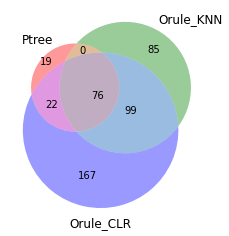

In [32]:
set1 = set(ptree_vindex)
set2 = set(knn_vindex)
set3 = set(clr_vindex)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
venn3([set1, set2, set3], ('Ptree', 'Orule_KNN', 'Orule_CLR'), ax=ax)

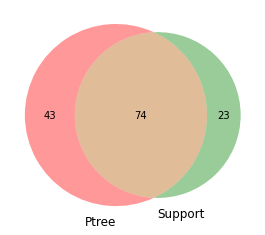

In [33]:
set1 = set(ptree_vindex)
set2 = set(support_vindex)
fig, ax = plt.subplots()
venn2([set1, set2], ('Ptree', 'Support'), ax=ax)

In [33]:
import time
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn3' + timestamp + '.pdf')

In [34]:
overlap_Xdf = X_df.loc[~X_df.index.isin(clr_vindex)]
overlap_adf = a.loc[~X_df.index.isin(clr_vindex)]
overlap_ydf = y.loc[~X_df.index.isin(clr_vindex)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [35]:
concat_df.to_csv(folder + '/data/fp_select_overlap_clr-et-2.csv', index=False)

In [87]:
len(X_df)/4973

0.9368590388095717